<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Input-preparation" data-toc-modified-id="Input-preparation-1">Input preparation</a></span></li><li><span><a href="#Create-mosaics" data-toc-modified-id="Create-mosaics-2">Create mosaics</a></span><ul class="toc-item"><li><span><a href="#Parallel-production" data-toc-modified-id="Parallel-production-2.1">Parallel production</a></span></li></ul></li><li><span><a href="#xy2latlon" data-toc-modified-id="xy2latlon-3">xy2latlon</a></span><ul class="toc-item"><li><span><a href="#Execute-campt-for-all-obsids" data-toc-modified-id="Execute-campt-for-all-obsids-3.1">Execute <code>campt</code> for all obsids</a></span></li><li><span><a href="#Combine-obsid-results-and-merge-with-marking-related-files" data-toc-modified-id="Combine-obsid-results-and-merge-with-marking-related-files-3.2">Combine obsid results and merge with marking related files</a></span></li></ul></li><li><span><a href="#Tile-coordinates" data-toc-modified-id="Tile-coordinates-4">Tile coordinates</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Check-for-presence-of-campt-files" data-toc-modified-id="Check-for-presence-of-campt-files-4.0.1">Check for presence of campt files</a></span></li></ul></li></ul></li><li><span><a href="#Metadata" data-toc-modified-id="Metadata-5">Metadata</a></span></li></ul></div>

# Input preparation

In [5]:
from hirise_tools.downloads import download_RED_product
from hirise_tools.products import RED_PRODUCT_ID

In [6]:
import logging
from nbtools.logging import setup_live_logging

In [10]:
from planet4 import io

In [11]:
db = io.DBManager()

In [96]:
roi = region_data.Potsdam()
obsids = roi.seasons
obsids

In [12]:
obsids = db.obsids
len(obsids)

221

In [13]:
setup_live_logging('planet4', logging.DEBUG)

<Logger planet4 (DEBUG)>

# Create mosaics

In [15]:
from planet4.projection import create_RED45_mosaic
from planet4 import io

In [16]:
from nbtools import execute_in_parallel

In [17]:
len(obsids)

221

In [18]:
results = execute_in_parallel(create_RED45_mosaic, obsids)

IntProgress(value=0, max=220)

In [19]:
for res in results:
    print(res)

('ESP_012079_0945', True)
('ESP_011697_0980', True)
('ESP_021455_0935', True)
('ESP_012008_0975', True)
('ESP_012436_0980', True)
('ESP_020347_0930', True)
('ESP_020519_0935', True)
('ESP_011931_0945', True)
('ESP_011960_0925', True)
('ESP_012291_0980', True)
('ESP_012077_0930', True)
('ESP_011341_0980', True)
('ESP_011711_0930', True)
('ESP_021495_0935', True)
('ESP_020742_0925', True)
('ESP_012063_0945', True)
('ESP_020357_0950', True)
('ESP_021642_0980', True)
('ESP_011350_0945', True)
('ESP_012884_0935', True)
('ESP_011900_0985', True)
('ESP_021494_0945', True)
('ESP_021454_0925', True)
('ESP_020339_0985', True)
('ESP_020954_0935', True)
('ESP_012499_0930', True)
('ESP_011407_0945', True)
('ESP_020476_0950', True)
('ESP_020748_0985', True)
('ESP_020782_0945', True)
('ESP_021526_0985', True)
('ESP_012251_0935', True)
('ESP_021491_0950', True)
('ESP_020677_0980', True)
('ESP_020779_0950', True)
('ESP_012344_0950', True)
('ESP_021587_0980', True)
('ESP_012227_0980', True)
('ESP_011447

## Parallel production

In [9]:
from ipyparallel import Client
c = Client()

lbview = c.load_balanced_view()
dview = c.direct_view()

In [10]:
with c[:].sync_imports():
    from planet4.projection import create_RED45_mosaic

importing create_RED45_mosaic from planet4.projection on engine(s)


In [11]:
results = lbview.map_async(create_RED45_mosaic, obsids)

In [12]:
from nbtools import display_multi_progress

In [13]:
display_multi_progress(results, obsids)

KeyboardInterrupt: 

In [15]:
for res in results:
    print(res)

('ESP_011697_0980', True)
('ESP_011842_0980', True)
('ESP_012053_0980', True)
('ESP_012264_0980', True)
('ESP_012607_0980', True)
('ESP_021969_0980', True)
('ESP_020756_0980', True)
('ESP_020677_0980', True)


# xy2latlon

In [9]:
from pysis.isis import campt
from pysis.exceptions import ProcessError
import pvl
from planet4 import io, catalog_production as cp

In [10]:
from pathlib import Path

# clusterpath = io.analysis_folder() / 'p4_catalog'
rm = cp.ReleaseManager('v1.0b4')

In [212]:
rm.merge_all()

In [11]:
obsids = rm.obsids

In [18]:
with dview.sync_imports():
    from pysis.isis import campt
    from pysis.exceptions import ProcessError
    from pathlib import Path
    from ipyparallel import CompositeError

importing campt from pysis.isis on engine(s)
importing ProcessError from pysis.exceptions on engine(s)
importing Path from pathlib on engine(s)
importing CompositeError from ipyparallel on engine(s)


In [79]:
def do_campt(mosaicname, savepath, temppath):
    try:
        campt(from_=mosaicname, to=savepath, format='flat', append='no',
              coordlist=temppath, coordtype='image')
    except ProcessError as e:
        print(e.stderr)
        return obsid, False

def obsid_marking_from_clusterpath(inpath):
    """Find obsid and marking kind from HiRISE cluster path.
    
    For example, a cluster path like this:
    '/Users/klay6683/Dropbox/data/planet4/p4_analysis/p4_catalog/ESP_011350_0945_blotches.csv'
    will return:
    ('ESP_011350_0945', 'blotches')
    """
    s = inpath.stem  # stem is 'name' (without folders) minus extension
    # s = ESP_xxxxxx_yyyy_blotches (or ..._fans)
    # obsid = s[:until last '_']
    sep = s.rfind('_')
    return s[:sep], s[sep+1:]

 

In [19]:
class XY2LATLON:
    edrpath = io.get_ground_projection_root()
    def __init__(self, df, inpath, overwrite=False, obsid=None):
        self.obsid = obsid
        self.df = df
        self.inpath = inpath
        self.overwrite = overwrite
        self.edrpath = io.get_ground_projection_root()
        self._obsid = obsid
            
    @property
    def obsid(self):
        return self.df.image_name.iloc[0] if self._obsid is None else self._obsid

    @obsid.setter
    def obsid(self, value):
        self._obsid = value
            
    @property
    def mosaicname(self):
        return f"{self.obsid}_mosaic_RED45.cub"
    
    @property
    def mosaicpath(self):
        return self.edrpath / self.obsid / self.mosaicname
        
    @property
    def savepath(self):
        return self.inpath / f"{self.obsid}_campt_out.csv"
        
    @property
    def savepath_blotch(self):
        return self.inpath / f"{self.obsid}_blotch_campt_out.csv"
    
    @property
    def savepath_fan(self):
        return self.inpath / f"{self.obsid}_fan_campt_out.csv"
    
    @property
    def temppath(self):
        return self.inpath / f"{self.obsid}.tocampt"
    
    def process_inpath(self):
        df = self.df
        tempcoords = ['image_x', 'image_y']
        df[tempcoords].to_csv(str(self.temppath), header=False, index=False)
        if self.savepath.exists() and self.overwrite is False:
            return
        try:
            do_campt(self.mosaicpath, self.savepath, self.temppath)
        except Exception as e:
            print(e)
            return False
        
    def combine_marking_files(self):
        try:
            f = pd.read_csv(self.savepath_fan)
        except FileNotFoundError:
            f = None
        try:
            b = pd.read_csv(self.savepath_blotch)
        except FileNotFoundError:
            b = None
        pd.concat([f, b]).to_csv(self.savepath, index=False)

In [82]:
def xy2latlon(inpath):
    d = dict(inpath=inpath)
    xy = XY2LATLON(inpath)
    ok = xy.process_inpath()  #inpath, *marking_mosaicpath_from_inpath(inpath))
    d['ok'] = ok
    return d

In [14]:
blotches = rm.read_blotch_file().drop_duplicates()
fans = rm.read_fan_file().drop_duplicates()
combined = pd.concat([blotches, fans])

In [16]:
obsids = combined.obsid.unique()

In [17]:
len(obsids)

221

In [20]:
for obsid in obsids:
    xy = XY2LATLON(combined, rm.savefolder, obsid=obsid)
    xy.combine_marking_files()

## Execute `campt` for all obsids

In [33]:
from tqdm import tqdm

for obsid in tqdm(obsids):
    data = combined[combined.image_name==obsid]
    xy = XY2LATLON(data, rm.savefolder)
    xy.process_inpath()

  0%|          | 0/221 [00:00<?, ?it/s]


AttributeError: 'DataFrame' object has no attribute 'image_name'

## Combine obsid results and merge with marking related files 

In [106]:
pd.set_option('display.max_columns', 100)

In [208]:
cols_to_merge = ("image_name image_x image_y PlanetocentricLatitude PlanetographicLatitude "
                 "PositiveEast360Longitude BodyFixedCoordinateX BodyFixedCoordinateY "
                 "BodyFixedCoordinateZ".split())
index = ['image_name', 'image_x', 'image_y']

def combine_campt_into_catalog():
    for marking in ['fans', 'blotches']:
        print(marking)
        data = eval(marking)
        bucket = []
        for obsid in obsids:
            df = data.query('image_name==@obsid')
            if df.shape[0] == 0:
                continue
            xy = XY2LATLON(df, rm.savefolder, obsid=obsid)
            savepath = xy.savepath_blotch if marking=='blotches' else xy.savepath_fan
            bucket.append(pd.read_csv(savepath).assign(image_name=obsid))

        ground = pd.concat(bucket).drop_duplicates()
        ground.rename(dict(Sample='image_x', Line='image_y'), axis=1, inplace=True)

        data.sort_values(by=index, inplace=True)
        ground.sort_values(by=index, inplace=True)

        merged = data.merge(ground[cols_to_merge], on=index)
        savepath = rm.blotch_merged if marking == 'blotches' else rm.fan_merged
        if marking == 'fans':
            merged.version = merged.version.astype('int')
        merged.to_csv(savepath, index=False)

In [32]:
cols_to_merge = ("obsid image_x image_y PlanetocentricLatitude PlanetographicLatitude "
                 "PositiveEast360Longitude BodyFixedCoordinateX BodyFixedCoordinateY "
                 "BodyFixedCoordinateZ".split())

index = ['obsid', 'image_x', 'image_y']

def get_all_campt_results():
    bucket = []
    for obsid in obsids:
        xy = XY2LATLON(None, rm.savefolder, obsid=obsid)
        bucket.append(pd.read_csv(xy.savepath).assign(obsid=obsid))

    ground = pd.concat(bucket).drop_duplicates()
    ground.rename(dict(Sample='image_x', Line='image_y'), axis=1, inplace=True)
    return ground
    
def combine_campt_into_catalog(fans, blotches):
    ground = get_all_campt_results()

    fans = fans.merge(ground[cols_to_merge], on=index)
    blotches = blotches.merge(ground[cols_to_merge], on=index)
    return fans, blotches

[autoreload of planet4.catalog_production failed: Traceback (most recent call last):
  File "/Users/klay6683/miniconda3/envs/stable/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 246, in check
    superreload(m, reload, self.old_objects)
  File "/Users/klay6683/miniconda3/envs/stable/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 369, in superreload
    module = reload(module)
  File "/Users/klay6683/miniconda3/envs/stable/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/Users/klay6683/miniconda3/envs/stable/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._boot

In [22]:
ground = get_all_campt_results()

In [27]:
fans.shape

(159040, 18)

In [28]:
fans.merge(ground[cols_to_merge], on=index).shape

(159040, 24)

In [29]:
blotches.shape

(250168, 17)

In [30]:
blotches.merge(ground[cols_to_merge], on=index).shape

(250168, 23)

In [23]:
fans.columns

Index(['angle', 'distance', 'tile_id', 'image_x', 'image_y', 'marking_id',
       'n_votes', 'obsid', 'spread', 'version', 'vote_ratio', 'x', 'x_angle',
       'y', 'y_angle', 'l_s', 'map_scale', 'north_azimuth'],
      dtype='object')

# Tile coordinates

In [40]:
from planet4.projection import TileCalculator, xy_to_hirise
from planet4 import projection as proj

In [32]:
edrpath = io.get_ground_projection_root()
edrpath

PosixPath('/Volumes/Data/planet4/p4_ground_projection')

In [33]:
obsids.shape

(221,)

In [34]:
cubepaths = [edrpath / obsid / f"{obsid}_mosaic_RED45.cub" for obsid in obsids]

In [35]:
cubepaths[:3]

[PosixPath('/Volumes/Data/planet4/p4_ground_projection/ESP_012079_0945/ESP_012079_0945_mosaic_RED45.cub'),
 PosixPath('/Volumes/Data/planet4/p4_ground_projection/ESP_011697_0980/ESP_011697_0980_mosaic_RED45.cub'),
 PosixPath('/Volumes/Data/planet4/p4_ground_projection/ESP_021455_0935/ESP_021455_0935_mosaic_RED45.cub')]

In [32]:
# testing
tc = TileCalculator(cubepaths[0])

tc.calc_tile_coords()

df = pd.read_csv(tc.campt_results_path)

pd.set_option('max_columns', 60)

%matplotlib inline

### Check for presence of campt files

In [42]:
todo=[]
for cubepath in cubepaths:
    tilecalc = proj.TileCalculator(cubepath, read_data=False)
    if not tilecalc.campt_results_path.exists():
        todo.append(cubepath)
print(f"{len(todo)} still todo.")

64 still todo.


In [47]:
def get_tile_coords(cubepath):
    from planet4.projection import TileCalculator
    tilecalc = TileCalculator(cubepath)
    tilecalc.calc_tile_coords()

In [48]:
results = execute_in_parallel(get_tile_coords, todo)

IntProgress(value=0, max=63)

In [49]:
len(cubepaths)

221

In [67]:
bucket = []
from tqdm import tqdm
for cubepath in tqdm(cubepaths):
    tilecalc = proj.TileCalculator(cubepath, read_data=False)
    bucket.append(tilecalc.tile_coords_df)

coords = pd.concat(bucket, ignore_index=True)

100%|██████████| 221/221 [00:00<00:00, 370.01it/s]


In [68]:
coords.shape

(42904, 18)

In [69]:
coords.head()

,BodyFixedCoordinateX,BodyFixedCoordinateY,BodyFixedCoordinateZ,Line,LineResolution,PlanetocentricLatitude,PlanetographicLatitude,PositiveEast360Longitude,PositiveWest360Longitude,Sample,SampleResolution,image_id,obsid,x_hirise,x_tile,xy_hirise,y_hirise,y_tile
0,-68.380673,256.056147,-3370.636698,324.0,0.246927,-85.504144,-85.556701,104.952104,NaN,420.0,0.246927,APF0000cwz,ESP_012079_0945,420.0,1,NaN,324.0,1
1,-68.331337,256.181661,-3370.628630,872.0,0.246926,-85.502300,-85.554878,104.934805,NaN,420.0,0.246926,APF0000ck9,ESP_012079_0945,420.0,1,NaN,872.0,2
2,-68.281853,256.307249,-3370.620295,1420.0,0.246926,-85.500454,-85.553054,104.917486,NaN,420.0,0.246926,APF0000cty,ESP_012079_0945,420.0,1,NaN,1420.0,3
3,-68.232522,256.433112,-3370.615690,1968.0,0.246922,-85.498607,-85.551228,104.900197,NaN,420.0,0.246922,APF0000ciy,ESP_012079_0945,420.0,1,NaN,1968.0,4
4,-68.183281,256.558509,-3370.606455,2516.0,0.246923,-85.496762,-85.549404,104.882968,NaN,420.0,0.246923,APF0000cwp,ESP_012079_0945,420.0,1,NaN,2516.0,5


In [71]:
catalog = 'catalog_1.0b3'

In [109]:
savefolder = io.analysis_folder() / catalog / f"{roi.name.lower()}"
savefolder.mkdir(exist_ok=True)
savename = savefolder / f"{roi.name.lower()}_tile_coords.csv"

In [77]:
savefolder = io.data_root / catalog

In [78]:
savename = savefolder / "all_images_tile_coords.csv"

In [79]:
coords.to_csv(savename, index=False)

In [34]:
coords = pd.read_csv(savename)

In [80]:
coords.shape

(42904, 18)

In [81]:
coords.tail()

,BodyFixedCoordinateX,BodyFixedCoordinateY,BodyFixedCoordinateZ,Line,LineResolution,PlanetocentricLatitude,PlanetographicLatitude,PositiveEast360Longitude,PositiveWest360Longitude,Sample,SampleResolution,image_id,obsid,x_hirise,x_tile,xy_hirise,y_hirise,y_tile
42899,221.306585,-459.891857,-3341.920182,22244.0,0.534375,-81.317022,-81.417411,295.697530,NaN,1160.0,0.534375,APF0000ib0,ESP_022699_0985,1160.0,2,NaN,22244.0,41
42900,221.396980,-460.166815,-3341.874557,22792.0,0.534380,-81.312098,-81.412542,295.693292,NaN,1160.0,0.534380,APF0000ibd,ESP_022699_0985,1160.0,2,NaN,22792.0,42
42901,221.489427,-460.441688,-3341.833083,23340.0,0.534375,-81.307170,-81.407669,295.689270,NaN,1160.0,0.534375,APF0000ib2,ESP_022699_0985,1160.0,2,NaN,23340.0,43
42902,221.583849,-460.716174,-3341.795842,23888.0,0.534361,-81.302245,-81.402799,295.685471,NaN,1160.0,0.534361,APF0000id7,ESP_022699_0985,1160.0,2,NaN,23888.0,44
42903,221.678080,-460.991080,-3341.757629,24436.0,0.534349,-81.297312,-81.397922,295.681636,NaN,1160.0,0.534349,APF0000id9,ESP_022699_0985,1160.0,2,NaN,24436.0,45


In [31]:
%matplotlib nbagg

<IPython.core.display.Javascript object>


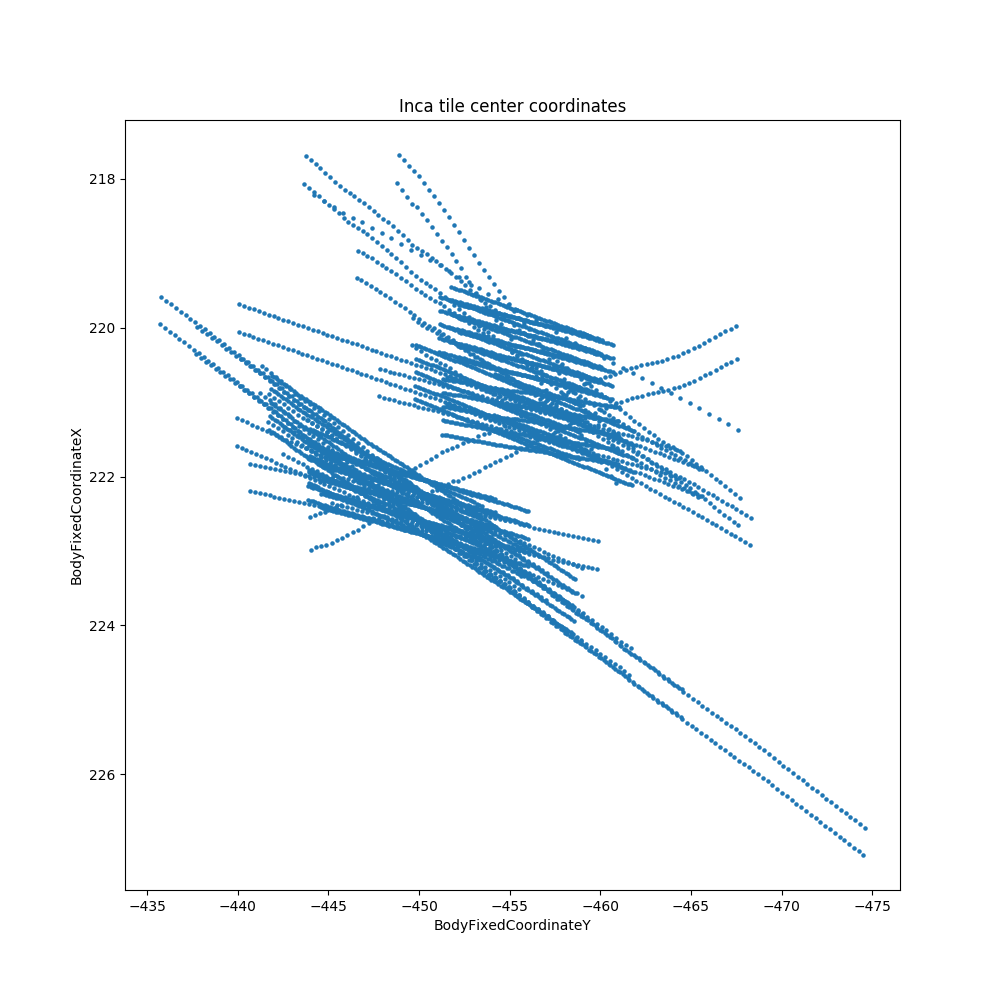

In [32]:
coords.plot(kind='scatter', marker='.', x='BodyFixedCoordinateY', y='BodyFixedCoordinateX')

In [35]:
ax = plt.gca()

ax.invert_xaxis()

ax.invert_yaxis()

ax.set_title(f"{roi} tile center coordinates")

fig = plt.gcf()

fig.savefig(f'/Users/klay6683/Dropbox/src/p4_paper1/figures/{roi.lower()}_tile_center_coordinates.png', dpi=200)

In [36]:
from matplotlib.colors import LogNorm

In [37]:
xycoords = coords['BodyFixedCoordinateX BodyFixedCoordinateY'.split()]

In [38]:
xrange = []
yrange = []
for col,bucket in zip(xycoords.columns, [xrange, yrange]):
    coord = xycoords[col]
    bucket.append(int(coord.min()))
    bucket.append(int(coord.max()))

In [39]:
xrange
yrange

[-474, -435]

In [40]:
gridres = 0.5
xedges = np.arange(xrange[0], xrange[1]+1, gridres)
yedges = np.arange(yrange[0], yrange[1]+1, gridres)

<IPython.core.display.Javascript object>


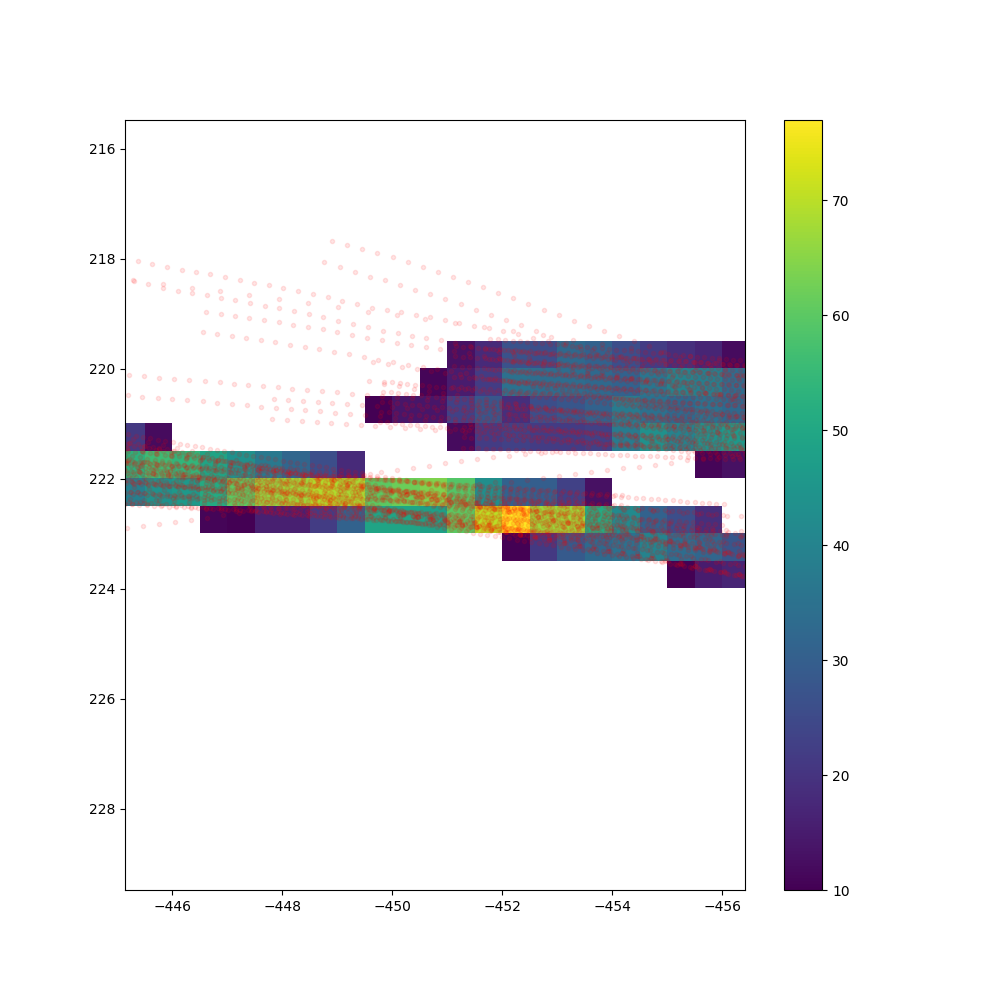

In [41]:
plt.figure()
plt.scatter(xycoords.BodyFixedCoordinateY, xycoords.BodyFixedCoordinateX,
            marker='.', alpha=0.1, color='red')

counts, y_ret, x_ret, _ = plt.hist2d(xycoords.BodyFixedCoordinateY, xycoords.BodyFixedCoordinateX,
           bins=[yedges, xedges], cmin=10)
plt.colorbar()

plt.hlines(yedges, *xrange, lw=0.5)
plt.vlines(xedges, *yrange, lw=0.5)
plt.gca().axes.set_aspect('equal', 'datalim')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
# plt.savefig('ithaca_coverage.png', dpi=200)

In [238]:
H, y_ret, x_ret = np.histogram2d(xycoords.BodyFixedCoordinateY, xycoords.BodyFixedCoordinateX,
           bins=[yedges, xedges])

In [370]:
yindices, xindices = np.where(H>11)

In [371]:
x1 = -288.402
y1 = -3.17798
x2 = -283.19
y2 = -6.21769
m = (y1-y2)/(x1-x2)
b = y1 - m*x1
b

-171.37798833077548

In [372]:
def f(x):
    return m*x + b

In [373]:
f(-288)

-3.4124319224865474

In [378]:
box1 = []
box2 = []
for xind, yind in zip(xindices, yindices):
    xlow = x_ret[xind]
    xhigh = x_ret[xind+1]
    xmean = (xlow+xhigh)/2
    ylow = y_ret[yind]
    yhigh = y_ret[yind+1]
    ymean = (ylow+yhigh)/2
    x_query = '@xlow < BodyFixedCoordinateX < @xhigh'
    y_query = '@ylow < BodyFixedCoordinateY < @yhigh'
    boxtmp = coords.query(f"{x_query} and {y_query}")
    if f(xmean) > ymean:  # if the separating line is above the current y-value
        box1.append(boxtmp)
    elif f(xmean) < ymean:
        if xmean > -281.5:
            box1.append(boxtmp)
        else:
            box2.append(boxtmp)
box1 = pd.concat(box1, ignore_index=True)
box2 = pd.concat(box2, ignore_index=True)

In [382]:
import seaborn as sns
sns.set_context('poster')

<IPython.core.display.Javascript object>


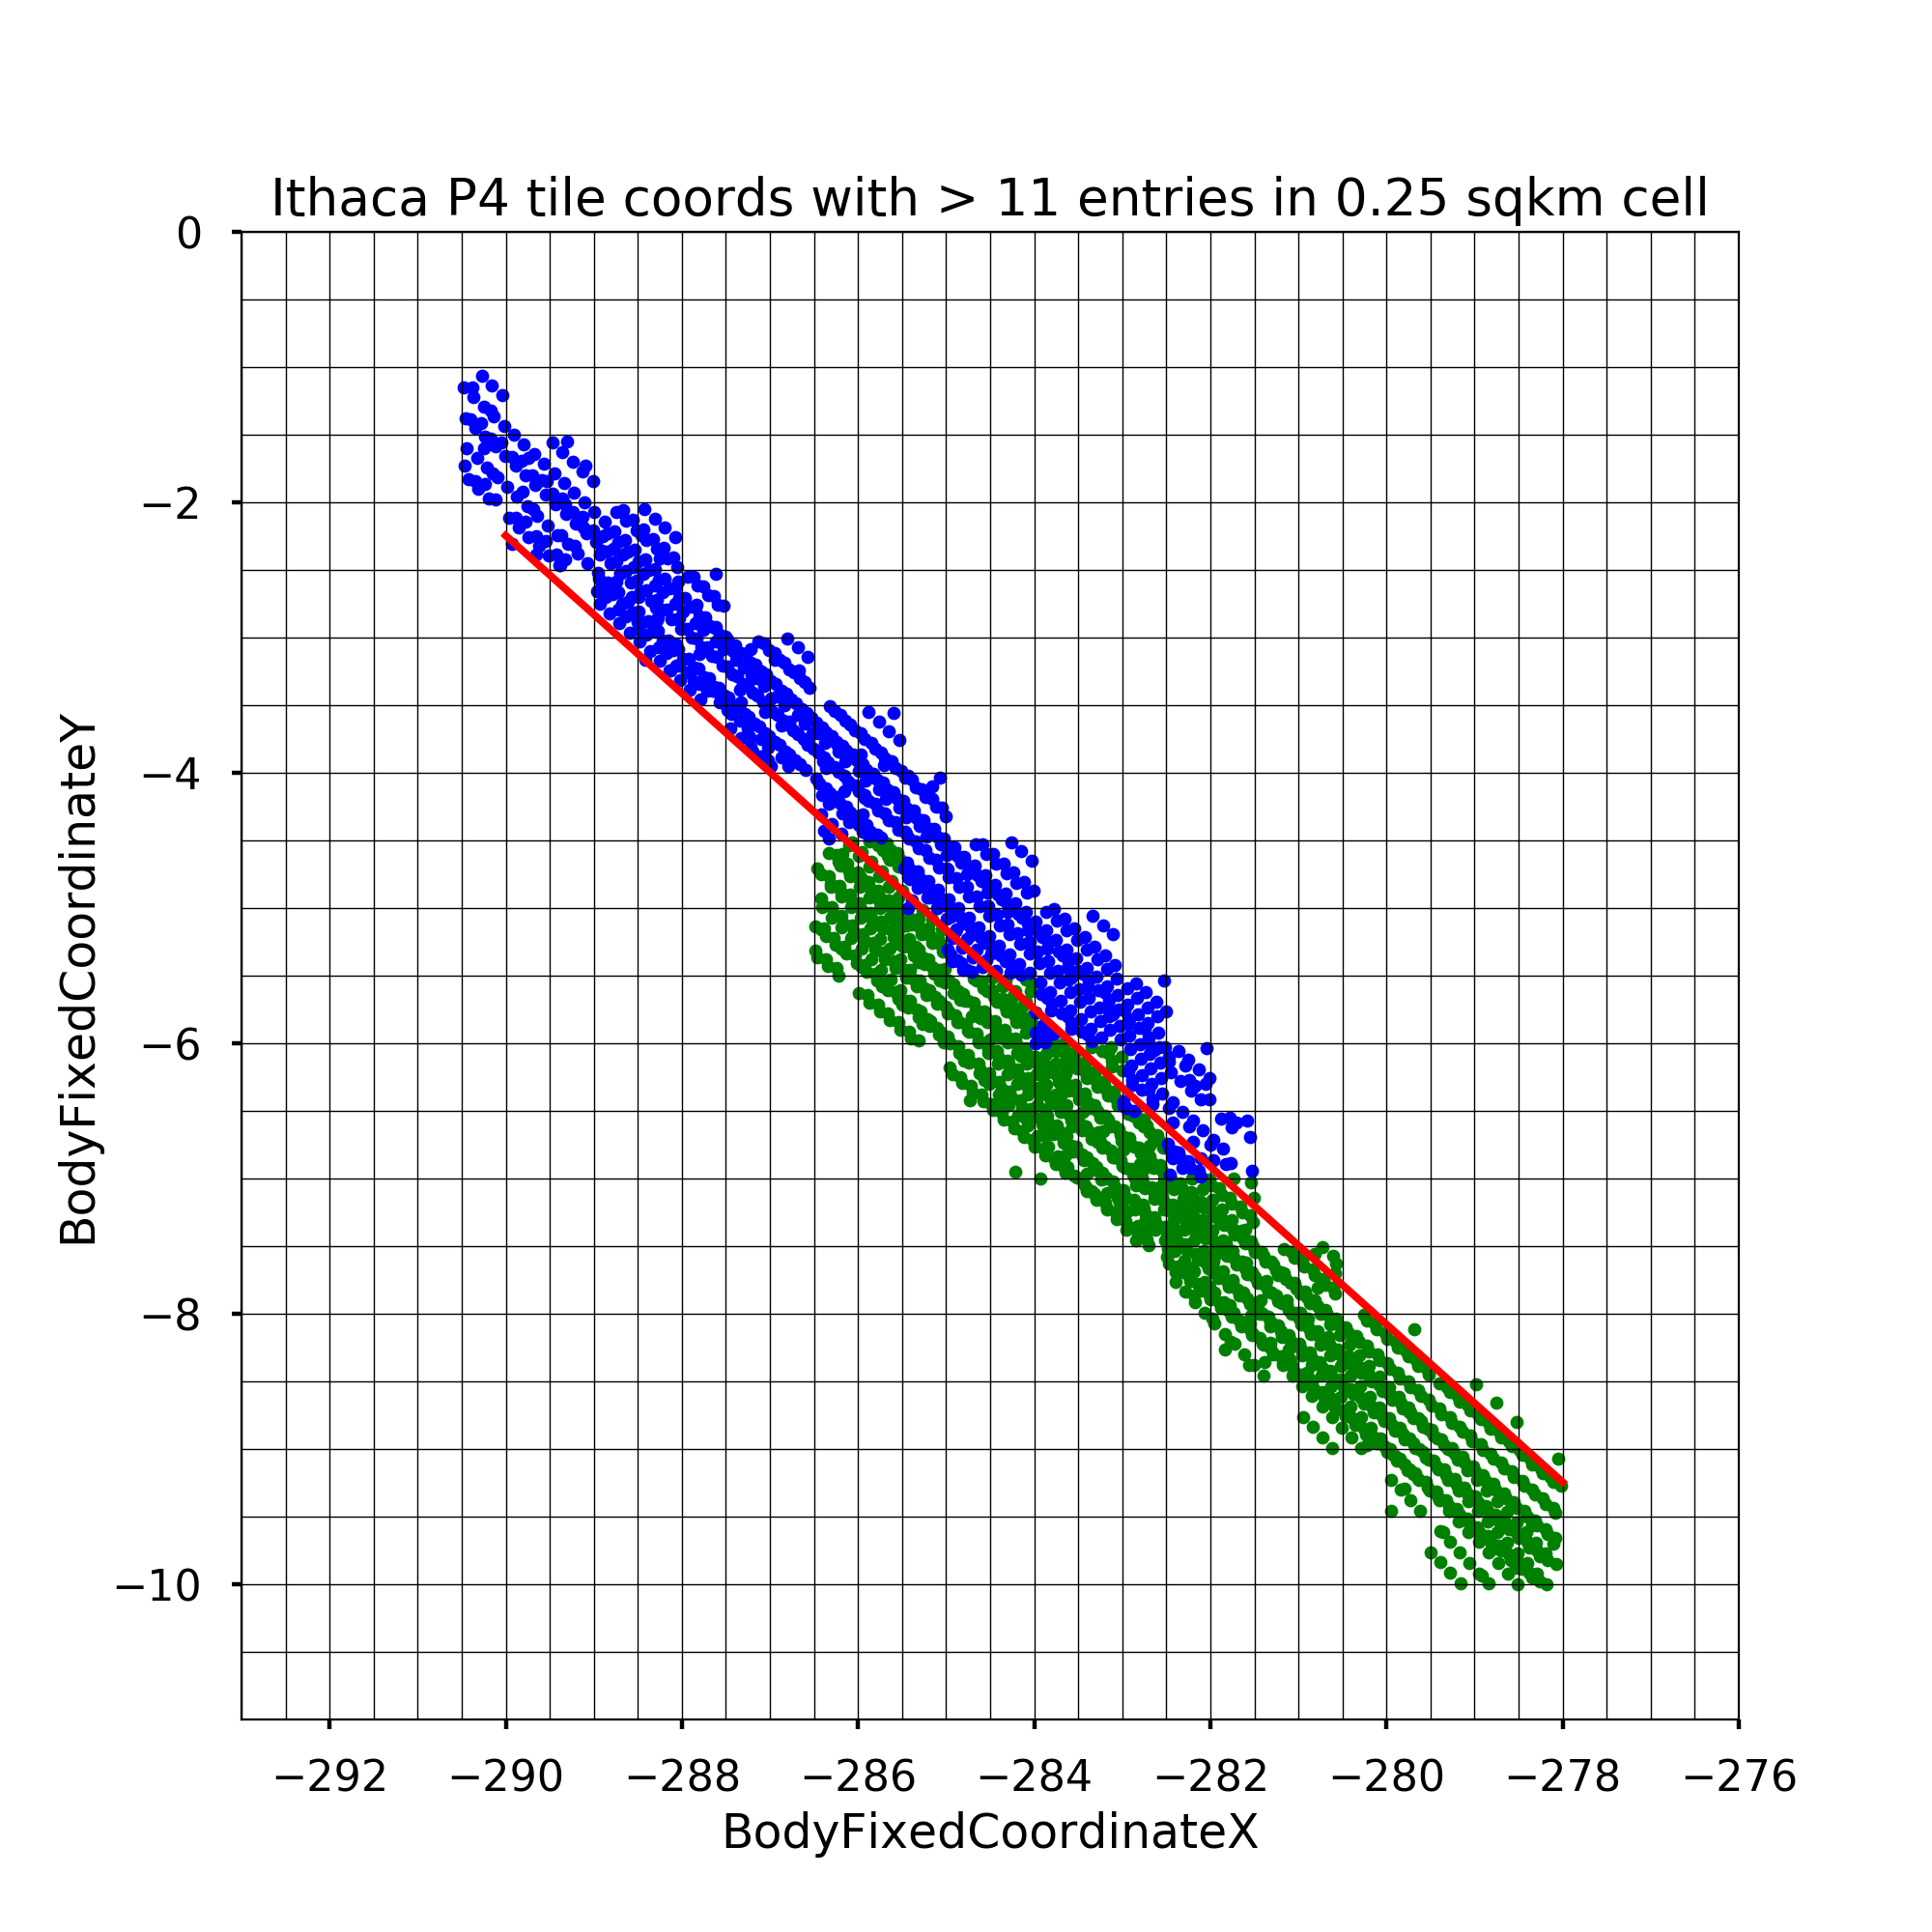

In [394]:
ax = box1.plot.scatter(x='BodyFixedCoordinateX', y='BodyFixedCoordinateY', color='green')
box2.plot.scatter(x='BodyFixedCoordinateX', y='BodyFixedCoordinateY', color='blue', ax=ax)
x = np.linspace(-290, -278, 100)
ax.plot(x, m*x+b, c='red')
ax.hlines(yedges, *xrange, lw=0.5)
ax.vlines(xedges, *yrange, lw=0.5)
ax.set_xlim(-293, -276)
ax.set_ylim(-11, 0)
ax.set_title("Ithaca P4 tile coords with > 11 entries in 0.25 sqkm cell")
fig = ax.get_figure()
fig.savefig("/Users/klay6683/Dropbox/p4_4Chase/ithaca/box_selection.png", dpi=200)

In [380]:
box1.image_id.to_csv('box1_image_ids.csv', index=False)
box2.image_id.to_csv('box2_image_ids.csv', index=False)

# Metadata

In [151]:
meta = pd.read_hdf('/Users/klay6683/Dropbox/SternchenAndMe/python_stuff/hirise_rdr_index.hdf')

In [155]:
colorimgs = meta[meta.PRODUCT_ID.str.endswith('_COLOR')]

In [156]:
coords = coords.merge(colorimgs, right_on='OBSERVATION_ID', left_on='image_name')

In [87]:
coords.SOLAR_LONGITUDE.max()

252.90700000000001

In [88]:
coords.columns

Index(['x_tile', 'y_tile', 'x_hirise', 'y_hirise', 'Sample', 'Line',
       'PlanetocentricLatitude', 'PlanetographicLatitude',
       'PositiveEast360Longitude', 'BodyFixedCoordinateX',
       'BodyFixedCoordinateY', 'BodyFixedCoordinateZ', 'LineResolution',
       'SampleResolution', 'image_id', 'image_name', 'absX', 'absY', 'invY',
       'invX', 'VOLUME_ID', 'FILE_NAME_SPECIFICATION', 'INSTRUMENT_HOST_ID',
       'INSTRUMENT_ID', 'OBSERVATION_ID', 'PRODUCT_ID', 'PRODUCT_VERSION_ID',
       'TARGET_NAME', 'ORBIT_NUMBER', 'MISSION_PHASE_NAME', 'RATIONALE_DESC',
       'OBSERVATION_START_TIME', 'OBSERVATION_START_COUNT', 'START_TIME',
       'SPACECRAFT_CLOCK_START_COUNT', 'STOP_TIME',
       'SPACECRAFT_CLOCK_STOP_COUNT', 'IMAGE_LINES', 'LINE_SAMPLES',
       'EMISSION_ANGLE', 'INCIDENCE_ANGLE', 'PHASE_ANGLE',
       'SPACECRAFT_ALTITUDE', 'TARGET_CENTER_DISTANCE', 'SLANT_DISTANCE',
       'NORTH_AZIMUTH', 'SUB_SOLAR_AZIMUTH', 'SUB_SOLAR_LATITUDE',
       'SUB_SOLAR_LONGITUDE', 'SUB_

In [110]:
coords.groupby('image_name').IMAGE_LINES.mean()

image_name
ESP_011350_0945    38405.5
ESP_011351_0945    41667.5
ESP_011403_0945    46462.0
ESP_011404_0945    38520.5
ESP_011931_0945    28562.5
ESP_012063_0945    39440.5
ESP_012076_0945    40277.0
ESP_012643_0945    40283.5
ESP_012854_0945    20170.5
ESP_012858_0855    18767.5
ESP_020146_0950    35869.5
ESP_020357_0950    70965.0
ESP_020476_0950    26887.0
ESP_020568_0950    28312.5
ESP_020779_0950    39770.0
ESP_021491_0950    35670.0
Name: IMAGE_LINES, dtype: float64